In [25]:
!pip install lpips

In [26]:

#!unzip -q /content/NH-HAZE.zip -d /content/nh_haze_data/
#!ls /content/nh_haze_data/

In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import torch.cuda.amp as amp

# Configuration
class Config:
    height = 128
    width = 128
    lr = 0.0002
    epochs = 10
    batch_size = 8
    val_batch_size = 1

    data_dir = "/content/nh_haze_data/NH-HAZE/NH-HAZE/"
    save_model_path = "dehazer_best.pth"
    subset_limit = 30

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_fn = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [28]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class EnhancedResBlock(nn.Module):
    def __init__(self, dim):
        super(EnhancedResBlock, self).__init__()
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.sa = SpatialAttention() # Spatial attention for non-homogeneous haze
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.relu(self.conv1(x))
        res = self.conv2(res)
        res = res * self.sa(res) # Apply spatial mask
        return x + res

class NHDehazeNet(nn.Module):
    def __init__(self, dim=64):
        super(NHDehazeNet, self).__init__()
        self.pre = nn.Sequential(nn.Conv2d(3, dim, 3, 1, 1), nn.ReLU(True))

        # 7 blocks with internal spatial attention
        self.blocks = nn.ModuleList([EnhancedResBlock(dim) for _ in range(7)])

        # Global Feature Fusion (Multi-scale)
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim, dim // 8, 1),
            nn.ReLU(True),
            nn.Conv2d(dim // 8, dim, 1),
            nn.Sigmoid()
        )
        self.post = nn.Sequential(nn.Conv2d(dim, 32, 3, 1, 1), nn.ReLU(True), nn.Conv2d(32, 3, 3, 1, 1))

    def forward(self, x):
        feat = self.pre(x)
        res = feat
        for block in self.blocks:
            res = block(res)

        # Apply Channel Attention to the fused features
        res = res * self.ca(res)
        out = self.post(res)
        return torch.clamp(x + out, 0, 1)

In [29]:
class NHHazeDataset(Dataset):
    def __init__(self, data_dir):
        hazy_files = sorted(glob.glob(os.path.join(data_dir, "*_hazy.png")))
        self.data_list = []
        for h_path in hazy_files:
            gt_path = h_path.replace("_hazy.png", "_GT.png")
            if os.path.exists(gt_path):
                self.data_list.append((h_path, gt_path))

        # Limit dataset size to fit in 15 mins
        if len(self.data_list) > config.subset_limit:
            self.data_list = self.data_list[:config.subset_limit]

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        h_path, g_path = self.data_list[idx]
        hazy = cv2.cvtColor(cv2.imread(h_path), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(g_path), cv2.COLOR_BGR2RGB)
        hazy = cv2.resize(hazy, (config.width, config.height)) / 255.0
        gt = cv2.resize(gt, (config.width, config.height)) / 255.0
        return torch.from_numpy(hazy).float().permute(2,0,1), torch.from_numpy(gt).float().permute(2,0,1)

full_ds = NHHazeDataset(config.data_dir)
indices = list(range(len(full_ds)))
np.random.seed(42)
np.random.shuffle(indices)

# 70-15-15 Split logic
t_size = int(0.7 * len(full_ds))
v_size = int(0.15 * len(full_ds))

train_loader = DataLoader(Subset(full_ds, indices[:t_size]), batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(Subset(full_ds, indices[t_size:t_size+v_size]), batch_size=1)
test_loader = DataLoader(Subset(full_ds, indices[t_size+v_size:]), batch_size=1)

In [30]:
def calculate_metrics_for_set(loader, model, set_name):
    model.eval()
    mse_list, psnr_list, ssim_list, lpips_list = [], [], [], []

    with torch.no_grad():
        for h, g in loader:
            h, g = h.to(device), g.to(device)
            out = model(h)

            # 1. LPIPS (requires batch-aware handling)
            lp = lpips_fn(out * 2 - 1, g * 2 - 1)
            lpips_list.append(lp.mean().item())

            # 2. Convert to Numpy for skimage metrics
            out_np = out.cpu().numpy().transpose(0, 2, 3, 1)
            gt_np = g.cpu().numpy().transpose(0, 2, 3, 1)

            for i in range(out_np.shape[0]):
                p, target = out_np[i], gt_np[i]
                mse_list.append(np.mean((p - target)**2))
                psnr_list.append(peak_signal_noise_ratio(target, p, data_range=1.0))
                ssim_list.append(structural_similarity(target, p, channel_axis=-1, data_range=1.0))

    print(f"\n--- {set_name} Metrics ---")
    print(f"MSE:   {np.mean(mse_list):.6f}")
    print(f"PSNR:  {np.mean(psnr_list):.2f} dB")
    print(f"SSIM:  {np.mean(ssim_list):.4f}")
    print(f"LPIPS: {np.mean(lpips_list):.4f}")

# --- Training Loop ---
model = NHDehazeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0004)
criterion = nn.L1Loss()
scaler = torch.cuda.amp.GradScaler()

print("Training NH-HAZE Optimized Model (15 min sprint)...")
for epoch in range(10): 
    model.train()
    for h, g in train_loader:
        h, g = h.to(device), g.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = criterion(model(h), g)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


calculate_metrics_for_set(train_loader, model, "TRAINING")
calculate_metrics_for_set(val_loader, model, "VALIDATION")
calculate_metrics_for_set(test_loader, model, "TESTING")

Training NH-HAZE Optimized Model (15 min sprint)...


/tmp/ipython-input-4124704333.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4124704333.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



--- TRAINING Metrics ---
MSE:   0.045263
PSNR:  13.76 dB
SSIM:  0.4237
LPIPS: 0.5131

--- VALIDATION Metrics ---
MSE:   0.049201
PSNR:  13.46 dB
SSIM:  0.3594
LPIPS: 0.6133

--- TESTING Metrics ---
MSE:   0.044325
PSNR:  13.78 dB
SSIM:  0.3958
LPIPS: 0.5100


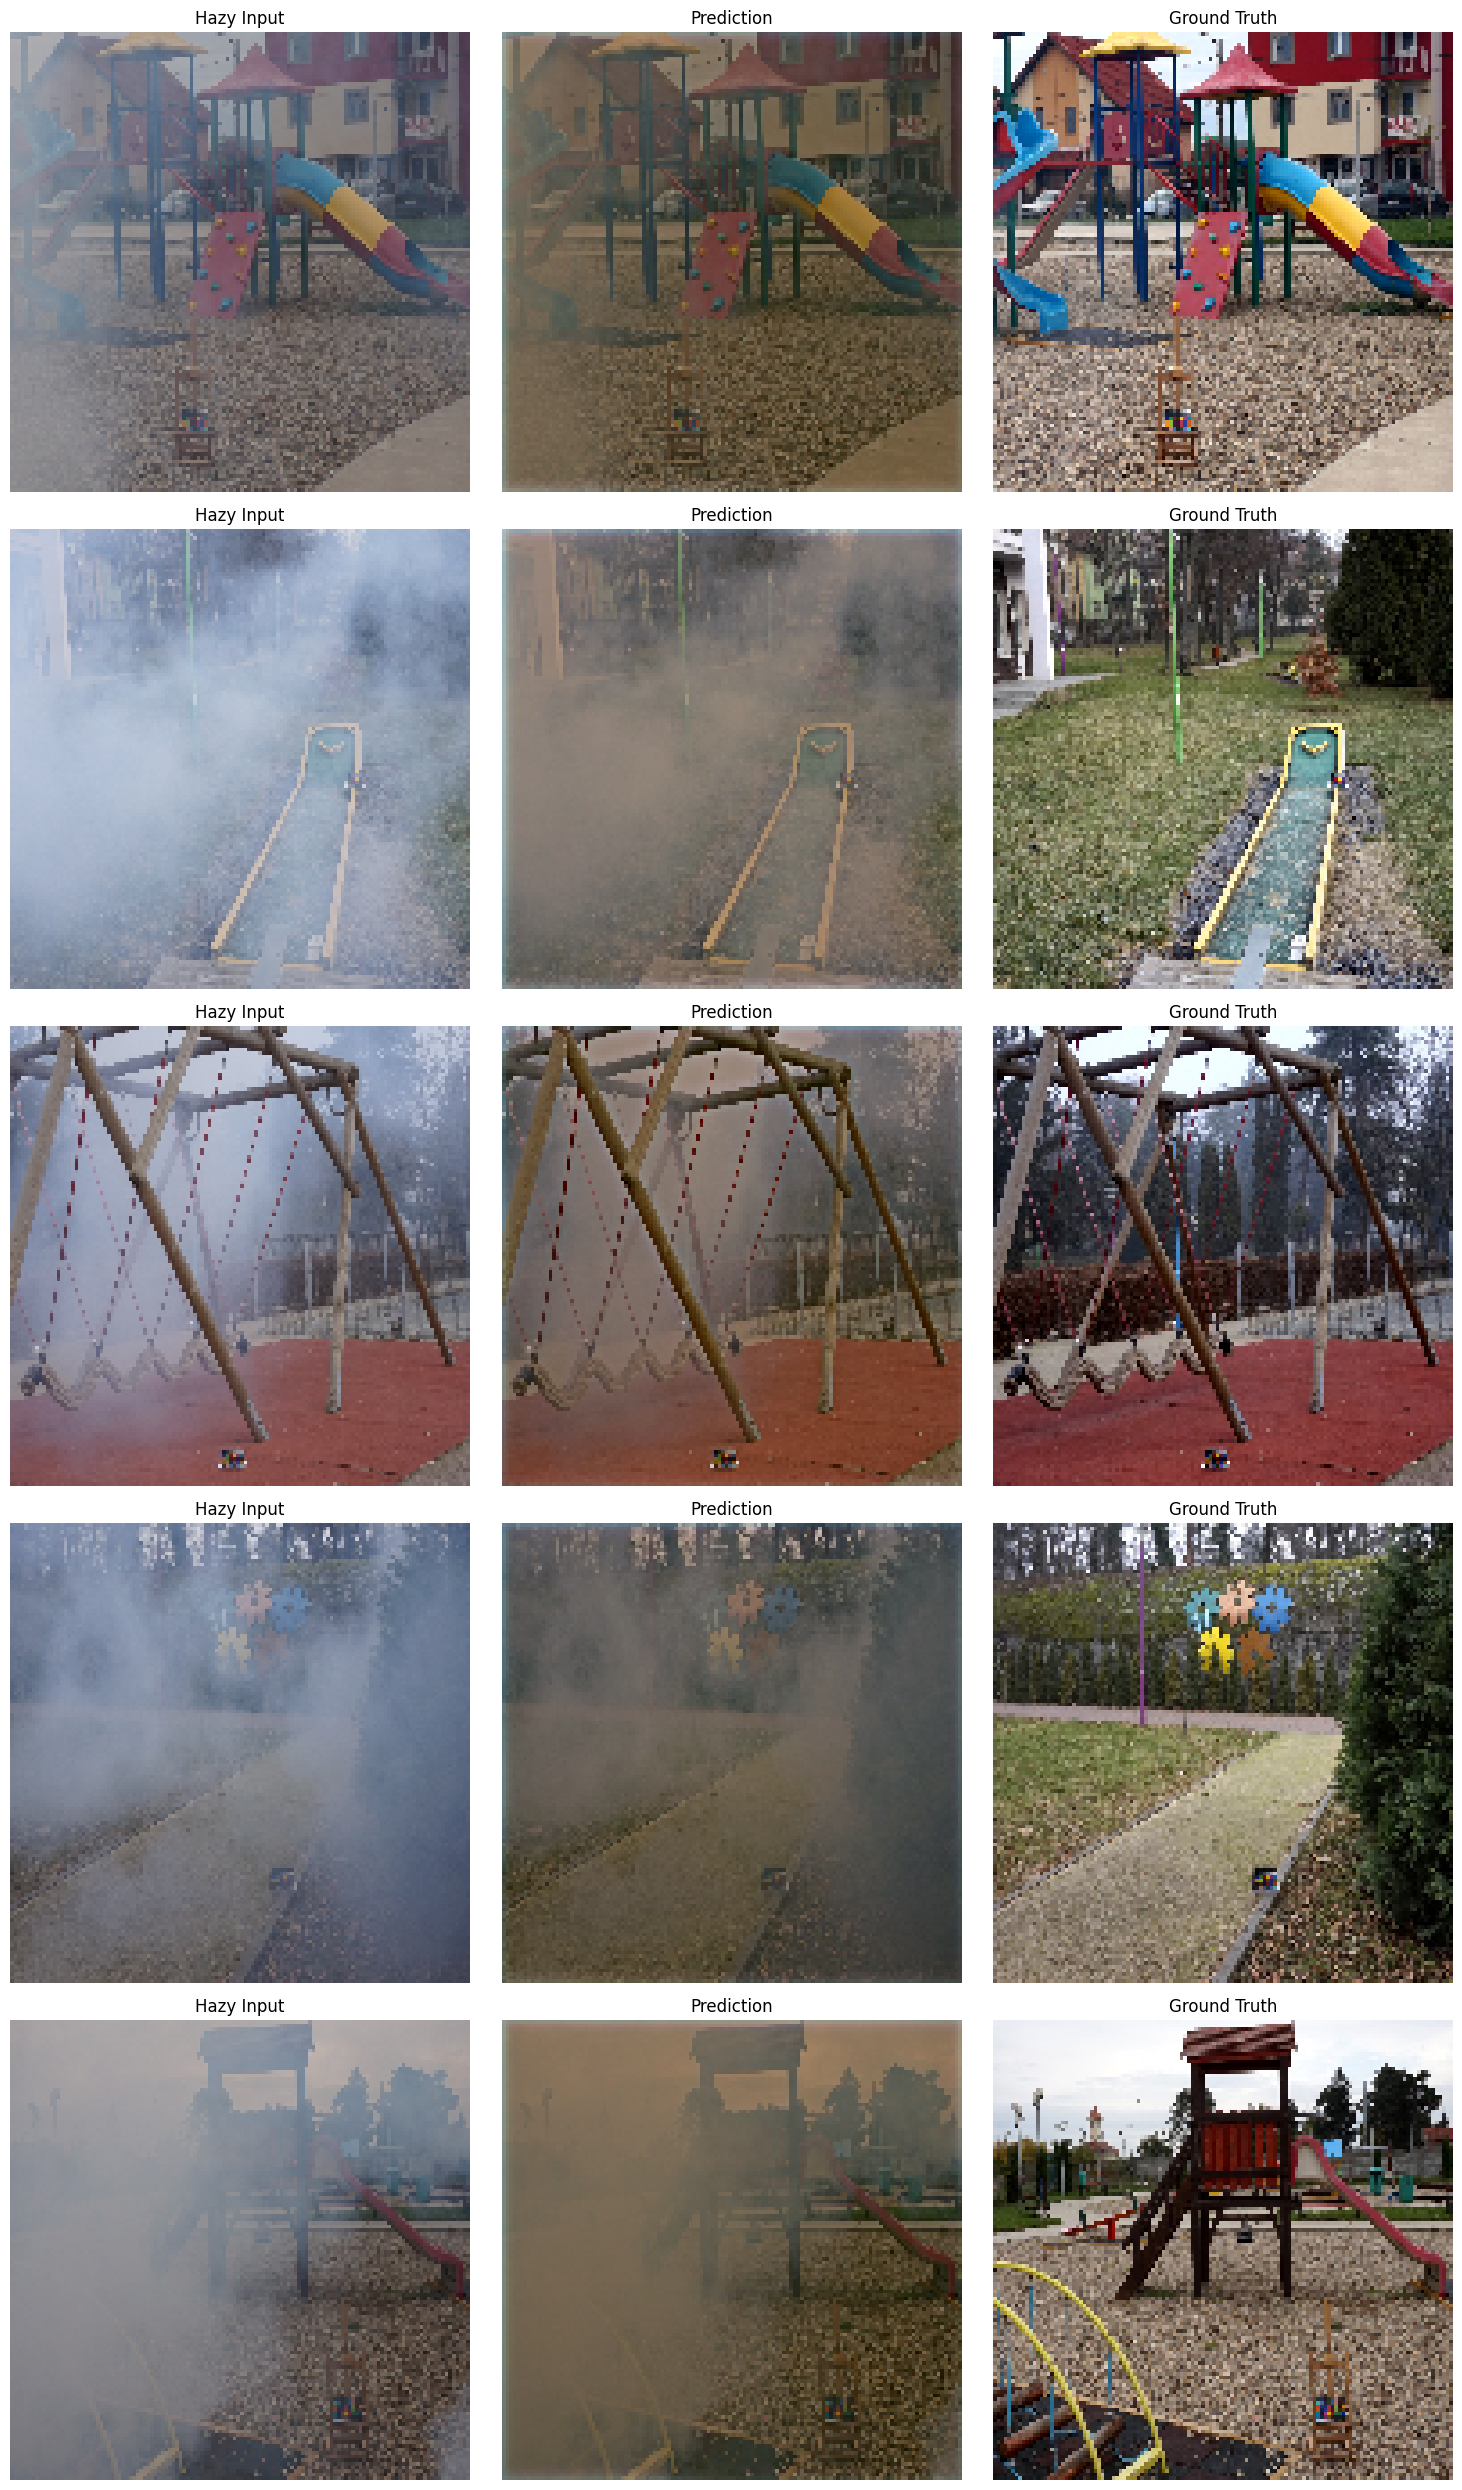

In [31]:
model.eval()

num_show = min(10, len(test_loader))
fig, axes = plt.subplots(num_show, 3, figsize=(15, 5 * num_show))

with torch.no_grad():
    for i, (h, g) in enumerate(test_loader):
        if i >= num_show: break
        out = torch.clamp(model(h.to(device)), 0, 1)
        axes[i, 0].imshow(h[0].permute(1,2,0)); axes[i,0].set_title("Hazy Input"); axes[i,0].axis('off')
        axes[i, 1].imshow(out[0].cpu().permute(1,2,0)); axes[i,1].set_title("Prediction"); axes[i,1].axis('off')
        axes[i, 2].imshow(g[0].permute(1,2,0)); axes[i,2].set_title("Ground Truth"); axes[i,2].axis('off')

plt.tight_layout()
plt.show()